<a href="https://colab.research.google.com/github/mehrshad-sdtn/Generative-Models/blob/master/autoencoder_sketching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
#! pip install -q kaggle

In [143]:
#from google.colab import files
#files.upload()

In [144]:
#! mkdir ~/.kaggle

In [145]:
#! cp kaggle.json ~/.kaggle/

In [146]:
#! chmod 600 ~/.kaggle/kaggle.json

In [147]:
#!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs

In [148]:
#! mkdir sketch_data

In [149]:
#! unzip cuhk-face-sketch-database-cufs.zip -d sketch_data

**Main Code**

In [150]:
%cd /content/drive/MyDrive/datasets/

/content/drive/MyDrive/datasets


In [151]:
import numpy as np
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
import matplotlib.pyplot as plt
import cv2
from os.path import join
import os
import re

In [152]:
wd = os.getcwd()

In [153]:
DIM = 256

In [154]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


def load_image(filepath):
  return cv2.cvtColor(
      cv2.imread(filepath), cv2.COLOR_BGR2GRAY)
  
def imshow(image):
  plt.imshow(image, cmap='gray')


def load_dir_images(path):
  array = []
  for img in [join(path, name) for name in sorted_alphanumeric(os.listdir(path))]:
    image = load_image(img)
    image = cv2.resize(image, (DIM, DIM))
    image = image.astype('float32') / 255.0
    array.append(image)
    img1 = cv2.flip(image, 1)
    array.append(img1)
    img2 = cv2.flip(image, -1)
    array.append(img2)
  return array


In [155]:
image_path = join(wd, 'sketch_data','photos')
img_array = load_dir_images(image_path)

sketch_path = join(wd, 'sketch_data','sketches')
sketch_array = load_dir_images(sketch_path)

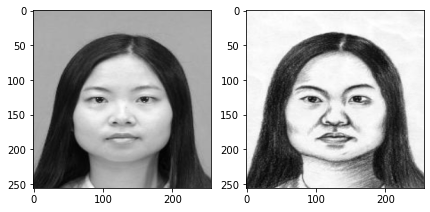

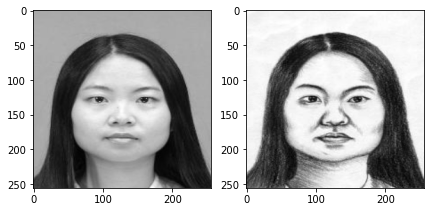

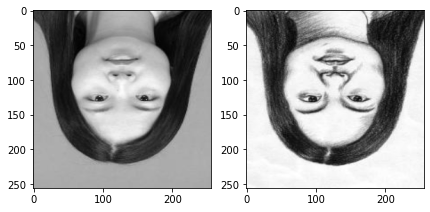

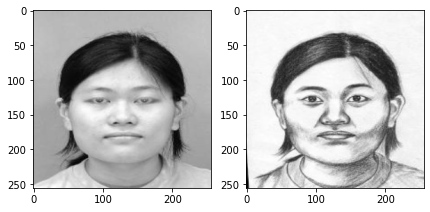

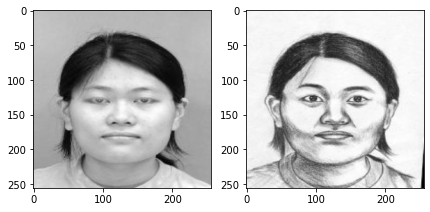

In [156]:
for i in range(0, 5):
  plt.figure(figsize=(7,7))
  plt.subplot(1, 2, 1)
  imshow(img_array[i])
  plt.subplot(1, 2, 2)
  imshow(sketch_array[i])
  plt.show()

In [157]:
print("Total number of sketch images:", len(sketch_array))
print("Total number of images:", len(img_array))

Total number of sketch images: 564
Total number of images: 564


In [158]:
dataset = list(zip(img_array, sketch_array))

In [159]:
import random

def train_test_split(dataset, ratio=0.9):
  length = int(len(dataset) * 0.9)
  return dataset[:length], dataset[length:]

train, test = train_test_split(dataset, ratio=0.9)

In [160]:
len(train), len(test)

(507, 57)

In [161]:
def split_data_label(dataset):
  X, y = [], []
  for data, label in dataset:
    X.append(data)
    y.append(label)
  return np.array(X), np.array(y)


X_train, y_train = split_data_label(train)
X_test, y_test = split_data_label(test)

In [162]:
X_train.shape, y_train.shape

((507, 256, 256), (507, 256, 256))

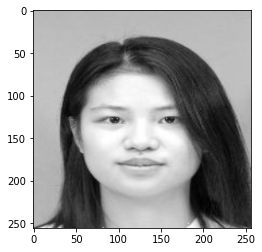

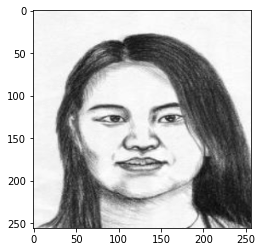

In [163]:
i = 10
imshow(X_train[i])
plt.show()
imshow(y_train[i])
plt.show()

In [164]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization: downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout: upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU()) 
    return upsample


encoder_input = keras.Input(shape=(DIM, DIM, 1), name="img")
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = MaxPool2D(pool_size = (2,2))(x)
x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid')(x)
x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same')(x)
x = MaxPool2D(pool_size = (2,2))(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
encoder = tf.keras.Model(encoder_input, encoder_output)

decoder_input = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_output)
x = UpSampling2D(size = (2,2))(decoder_input)
x = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
x = Conv2D(filters = 32 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
decoder_output = Conv2D(filters = 1, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)


model = keras.Model(encoder_input, decoder_output)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_50 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_51 (Conv2D)          (None, 63, 63, 32)        4640      
                                                                 
 conv2d_52 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                       

In [166]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(X_train, y_train, validation_split=0.1, epochs = 200)

Epoch 1/200
15/15 [==============================] - 4s 194ms/step - loss: 0.5705 - acc: 0.0169 - val_loss: 0.5110 - val_acc: 0.0221
Epoch 2/200
15/15 [==============================] - 3s 179ms/step - loss: 0.3479 - acc: 0.0297 - val_loss: 0.2195 - val_acc: 0.2593
Epoch 3/200
15/15 [==============================] - 3s 180ms/step - loss: 0.2333 - acc: 0.0333 - val_loss: 0.1917 - val_acc: 0.2636
Epoch 4/200
15/15 [==============================] - 3s 181ms/step - loss: 0.1837 - acc: 0.0327 - val_loss: 0.1607 - val_acc: 0.2655
Epoch 5/200
15/15 [==============================] - 3s 181ms/step - loss: 0.1365 - acc: 0.0325 - val_loss: 0.1393 - val_acc: 0.2662
Epoch 6/200
15/15 [==============================] - 3s 182ms/step - loss: 0.1201 - acc: 0.0324 - val_loss: 0.1203 - val_acc: 0.2671
Epoch 7/200
15/15 [==============================] - 3s 183ms/step - loss: 0.1099 - acc: 0.0324 - val_loss: 0.1297 - val_acc: 0.2669
Epoch 8/200
15/15 [==============================] - 3s 181ms/step - 

In [167]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 1s/step - loss: 0.0822 - acc: 0.2582


[0.08217199146747589, 0.2582218050956726]

In [168]:
preds = model.predict(X_test)

2/2 [==============================] - 0s 72ms/step


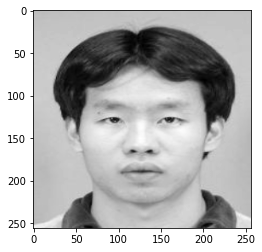

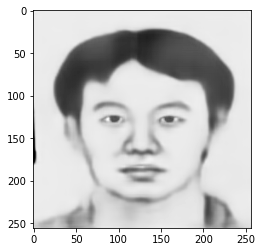

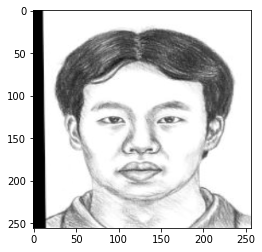

In [174]:
i = 22
imshow(X_test[i])
plt.show()
imshow(preds[i].reshape(DIM, DIM))
plt.show()
imshow(y_test[i])
plt.show()